In [1]:
import numpy as np
import os
import random
import math
import cmath
import multiprocessing
import random
import time
import matplotlib
import keras
import tensorflow as tf
from tensorflow.keras import backend as K 
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import h5py
from datetime import datetime
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard, LambdaCallback
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    UpSampling2D,
    Dropout,
    Lambda
)
from tensorflow.keras.metrics import (
    Recall,
    Precision
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from keras import Model
from statistics import mean, pstdev

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

In [3]:
import cv2
from scipy.io import loadmat
# Extract axis information to produce cone-shape images
def extract_axis(datapath, axisPath):
    data = loadmat(datapath)

    xaxis = np.array(list(data['xAxis']))
    yaxis = np.array(list(data['zAxis']))

    xaxis = cv2.resize(xaxis, (80, 256), interpolation=cv2.INTER_AREA)
    yaxis = cv2.resize(yaxis, (80, 256), interpolation=cv2.INTER_AREA)

    xaxis += 100
    yaxis -= 4

    print("saved axis info in : {}".format(axisPath))
    np.save(os.path.join(axisPath, "xAxis.npy"), xaxis)
    np.save(os.path.join(axisPath, "yAxis.npy"), yaxis)
    
    return xaxis, yaxis

In [4]:
# extract generic axis information
axisPath = "/DATA/phan92/notebooks"
rand_input_file = "/DATA/phan92/test_resource/raw_data/DoD110/DoD110_Ter002_LO1_Displacement_Normalized_3.mat"
xAxis, yAxis = extract_axis(rand_input_file, axisPath)

saved axis info in : /DATA/phan92/notebooks


In [5]:
def one_hot_binary(label, objective='skull'):
    """
    Create one hot label from the provided label
    The output has probability converted to int
    
    Args:
        label: label of shape (N, x_dim, y_dim)
        objective (string): objective of the model. brain, skull, or bleed
        
    Returns:
        label: onehot label (N, x_dim, y_dim, n_channels)
    """
    label = np.array(label)
    if objective == 'brain':
        # create label to find brain tissue
        # if the probability of brain is > 0, set the label to 1, 0 otherwise
        label = np.where(label > 0, 1, 0)
    elif objective == 'skull':
        # create label to find the skull
        # if the probability of skull is >= 0.5
        # set the label to 1, 0 otherwise
        label = np.where(label >= 0.5, 1, 0)
    elif objective == 'bleed':
        # create label to find bleed
        # if the probability of bleed is >= 0.3
        # set the label to 1
        label = np.where(label >= 0.3, 1, 0)
    else:
        raise ValueError("No objective with name \"{name}\"".format(name=objective))
    
    # add a n_channel dim
    label = np.expand_dims(label, axis=-1)
    #label = np.moveaxis(label, 3, 1)
    
    return label

In [6]:
def one_hot_raw(label):
    """
    Create one hot label from the provided label
    
    Args:
        label: label of shape (N, x_dim, y_dim, n_classes)
        objective (string): objective of the model. brain, skull, or bleed
        
    Returns:
        label: onehot label (N, x_dim, y_dim, n_channels)
    """
    # add a n_channel dim
    label = np.expand_dims(label, axis=-1)
    
    return label

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Read saved data and provide it to the model in batches
    """
    
    def __init__(self, group: h5py.Group, batch_size=32):
        self.x_dset: h5py.Dataset = group['x']
        self.y_dset: h5py.Dataset = group['y']
        self.batch_size = batch_size
    
    
    def __len__(self):
        """
        Get the numner of batches per epoch
        """
        return int(np.floor(self.x_dset.shape[0] / self.batch_size))
    
    
    def on_epoch_end(self):
        pass
    
    
    def __getitem__(self, batch_index:int):
        """
        Generate one batch of data
        :param batch_index: index of this batch
        :return: the data x and label y of the batch
        """
        batch_start = batch_index * self.batch_size
        batch_end = batch_start + self.batch_size

        x = self.x_dset[batch_start : batch_end]
        y = one_hot_raw(self.y_dset[batch_start : batch_end])
        
        return x, y

In [8]:
def dice_coefficient(y_true, y_pred, epsilon = 0.00001):
    """
    Compute mean dice coefficient over all class (2 x overlap / total pixels)
    
    Args:
        y_true (Tensorflow tensor): tensor of ground truth
                                    shape: (x_dim, y_dim, num_class)
        y_pred (Tensorflow tensor): tensor of soft prediction for all classes
                                    shape: (x_dim, y_dim, num_class)
        epsilon (float): small constant added to avoid divide by 0 error
    Return:
        dice_coefficient (float): computed value of dice coefficient
    """
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    dice_coeff = K.mean((2. * intersection + epsilon) / (total + epsilon))
    
    return dice_coeff

In [9]:
def iou(y_true, y_pred, epsilon=0.00001):
    """
    Compute mean intersection over union over all class (area of overlap / area of union)
    
    Args:
        y_true (Tensorflow tensor): tensor of ground truth
                                    shape: (x_dim, y_dim, num_class)
        y_pred (Tensorflow tensor): tensor of soft prediction for all classes
                                    shape: (x_dim, y_dim, num_class)
        epsilon (float): small constant added to avoid divide by 0 error
    Return:
        iou (float): computed value of intersection over union
    """
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = K.mean((intersection + epsilon) / (union + epsilon))
    
    return iou

In [10]:
def dice_loss(epsilon=0.00001):
    """
    Compute mean soft dice loss over all classes
    Soft dice loss operate on float probability output
    
    Args:
        y_true (Tensorflow tensor): tensor of ground truth
                                    shape: (x_dim, y_dim, num_class)
        y_pred (Tensorflow tensor): tensor of soft prediction for all classes
                                    shape: (x_dim, y_dim, num_class)
        epsilon (float): small constant added to avoid divide by 0 error
        
    Return:
        dice_loss (float): computed value of dice loss
    """
    def dice_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        dice_numerator = 2. * K.sum(y_true_f * y_pred_f) + epsilon
        dice_denominator = K.sum(y_true_f) + K.sum(y_pred_f) + epsilon
        loss = 1. - K.mean(dice_numerator / dice_denominator)
        
        return loss
    
    return dice_loss

In [11]:
def soft_dice_loss(epsilon=0.00001):
    """
    Compute mean soft dice loss over all classes
    Soft dice loss operate on float probability output
    The denominator is squared according to https://mediatum.ub.tum.de/doc/1395260/1395260.pdf
    
    Args:
        y_true (Tensorflow tensor): tensor of ground truth
                                    shape: (x_dim, y_dim, num_class)
        y_pred (Tensorflow tensor): tensor of soft prediction for all classes
                                    shape: (x_dim, y_dim, num_class)
        epsilon (float): small constant added to avoid divide by 0 error
        
    Return:
        dice_loss (float): computed value of dice loss
    """
    def dice_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        dice_numerator = 2. * K.sum(y_true_f * y_pred_f) + epsilon
        dice_denominator = K.sum(y_true_f**2) + K.sum(y_pred_f**2) + epsilon
        loss = 1. - K.mean(dice_numerator / dice_denominator)
        
        return loss
    
    return dice_loss

In [12]:
def weighted_bce(beta):
    """
    Compute the weighted binary cross entropy loss according to
        S. Jadon, “A survey of loss functions for semantic segmentation,” 
        2020 IEEE Conference on Computational Intelligence in Bioinformatics 
        and Computational Biology (CIBCB), pp. 1–7, Oct. 2020, doi: 10.1109/CIBCB48159.2020.9277638.
    
    Args:
        beta (int): weight factor for the positive class
    Return:
        wbce (float): weighted binary cross entropy score
    """
    def wbce(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        logloss = K.mean(-(beta * y_true * K.log(y_pred) + (1. - y_true) * K.log(1. - y_pred)))
        
        return logloss
    
    return wbce

In [13]:
def hybrid_loss(beta, epsilon=0.00001):
    """
    Compute a hybrid loss function which is sum of soft dice loss and weighted bce
    
    Args:
        beta (int): weight factor for the positive class
    Return:
        wbce (float): weighted binary cross entropy score
    """
    def loss(y_true, y_pred):
        # Calculate soft dice loss
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        dice_numerator = 2. * K.sum(y_true_f * y_pred_f) + epsilon
        dice_denominator = K.sum(y_true_f**2) + K.sum(y_pred_f**2) + epsilon
        dice_loss = 1. - K.mean(dice_numerator / dice_denominator)
        
        # Calculate weighted bce
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        wbce = K.mean(-(beta * y_true * K.log(y_pred) + (1. - y_true) * K.log(1. - y_pred)))
        
        hybrid = 2. * dice_loss + wbce
        return hybrid
    
    return loss

In [ ]:
def build_unet_model(input_layer, start_filters, dropout):
    # 128 -> 64
    conv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    # Middle
    convm = Conv2D(start_filters * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_filters * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_filters * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout)(uconv4)
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_filters * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout)(uconv3)
    uconv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(dropout)(uconv2)
    uconv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(dropout)(uconv1)
    uconv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [ ]:
def train(model, hdf5_file: str, checkpoint_dir: str, log_dir: str, epochs=50):
        """
        Trains UNet model with data contained in given HDF5 file and saves
        trained model to the checkpoint directory after each epoch
        
        Args:
            hdf5_file: Path of hdf5 file which contains the dataset
            checkpoint_dir (str): Directory where checkpoints are saved
            log_dir (str): Directory where logs are saved
            epochs (int): number of epochs
        """
        dataset = h5py.File(hdf5_file, 'r')
        
        training_generator = DataGenerator(dataset['dev'])
        validation_generator = DataGenerator(dataset['test'])
        
        # callback for tensorboard logs
        log_dir = os.path.join(log_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        os.makedirs(log_dir)
        tb_callback = TensorBoard(log_dir=log_dir, write_images=True)
        
        # callback to save trained model weights
        checkpoint_dir = os.path.join(checkpoint_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        os.makedirs(checkpoint_dir)
        weights_file = os.path.join(checkpoint_dir, 'unet.weights.epoch_{epoch:02d}.hdf5')
        checkpoint = ModelCheckpoint(weights_file, verbose=1)
        
        model.fit(training_generator,
                  validation_data=validation_generator,
                  callbacks=[tb_callback, checkpoint],
                  epochs=epochs)
        
        dataset.close()

In [ ]:
def cross_validation(num_folds, hdf5_file, start_filters, dropout_rate, epochs=50):
    """
    Perform kfold cross validation on the training set
    
    Args:
        num_folds (int): k in kfold
        hdf5 (string): path to hdf5 dataset
        epochs (int): number of epochs to train for
        
    Returns:
        loss_per_fold: list of loss values
        dice_per_fold: list of dice coefficient
    """
    dice_per_fold = []
    iou_per_fold = []
    loss_per_fold = []
    recall_per_fold = []
    precision_per_fold = []
    
    # get data
    f = h5py.File(hdf5_file, 'r')
    dev = f['dev']
    x = dev['x']
    y = one_hot_raw(dev['y'])
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
    
    fold_no = 1
    for train, test in kfold.split(x, y):
        K.clear_session()
        
        # build model
        input_layer = Input((256, 80, 1))
        output_layer = build_unet_model(input_layer, start_filters, dropout_rate)
        model = Model(input_layer, output_layer, )
        model.compile(optimizer='adam', 
                      loss=soft_dice_loss(epsilon=0.00001), 
                      metrics=[dice_coefficient, iou, Recall(), Precision()])
        
        print("Training for fold", fold_no, "....")
        history = model.fit(x[train], y[train], batch_size=32, epochs=epochs)
        score = model.evaluate(x[test], y[test])
        print("Score for fold", fold_no, ":")
        print("Dice loss =", score[0])
        print("Dice score =", score[1])
        print("IoU =", score[2])
        print("Recall =", score[3])
        print("Precision =", score[4])
        print()
        loss_per_fold.append(score[0])
        dice_per_fold.append(score[1])
        iou_per_fold.append(score[2])
        recall_per_fold.append(score[3])
        precision_per_fold.append(score[4])
        
        fold_no += 1
        
    f.close()
    
    return loss_per_fold, dice_per_fold, iou_per_fold, recall_per_fold, precision_per_fold

In [25]:
def visualize_result(label, prediction, displacement, name, xAxis, yAxis):
    """
    Display an input
    
    Args:
        label (numpy.arr): the label
        prediction (numpy.arr): the prediction
        displacement (numpy.arr): displacement
        name (string): name of the data file
        xAxis (numpy.arr): numpy array contain x axis for display the cone
        yAxis (numpy.arr): numpy array contain y axis for display the cone
        path (string): path to save image to
    """
    label = np.squeeze(label, axis=-1)
    prediction = np.squeeze(np.squeeze(prediction, axis=-1), axis=0)
    displacement = np.squeeze(displacement, axis=-1)
    
    name = name.split('.')[0]
    
    # display
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    fig.patch.set_facecolor('white')
    fig.suptitle(name, fontsize=16)
    # label
    ax[1].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma')
    ax[1].title.set_text("Ground Truth")
    ax[1].axis('off')
    # prediction
    ax[2].pcolormesh(xAxis, -yAxis, prediction, shading='auto', cmap='magma')
    ax[2].title.set_text("Prediction")
    ax[2].axis('off')
    # displacement
    ax[0].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
    ax[0].title.set_text("Standardized Displacement")
    ax[0].axis('off')
    plt.show()

In [26]:
def show_prediction(model, dataset, sample_num):
    x = dataset['x']
    y = dataset['y']
    names = dataset['filename']
    name = names[sample_num]
    sample = x[sample_num]
    y_true = one_hot_raw(y[sample_num])
    y_pred = model.predict(np.expand_dims(sample, axis=0))
    visualize_result(y_true, y_pred, sample, name.decode('utf-8'), xAxis, yAxis)

In [27]:
def show_specific_prediction(file_name:str, data_dir, model):
    """
    Make a prediction for a specific file
    
    Args:
        file_name: name of the .mat file (utf-8)
        data_dir: location of the saved dataset
        model: a trained model
    """
    data = h5py.File(data_dir)
    name_ascii = file_name.encode('ascii')
    canPredict = find_and_predict(data['test'], name_ascii, model)
    if not canPredict:
        canPredict = find_and_predict(data['dev'], name_ascii, model)
    data.close()
    if not canPredict:
        print(file_name, "not found")

In [28]:
def find_and_predict(dataset, file_name, model):
    """
    Make a prediction for a specific file
    
    Args:
        file_name: name of the .mat file (ascii)
        dataset: train or test data set (h5py dataset)
        model: a trained model
    
    Returns:
        True if the file exist, False otherwise
    """
    names = np.array(dataset['filename'])
    idx = np.where(names == file_name)[0]
    if idx.shape[0] > 0:
        idx = idx[0]
        show_prediction(model, dataset, idx)
        return True
    
    return False

In [29]:
def make_and_save_prediction(model, data_dir, save_dir):
    """
    Make a prediction for a sample using a trained model
    and save the result image to a file
    
    Args:
        model
        data_dir
        save_dir
        save_name
    """
    f = h5py.File(data_dir, 'r')
    test = f['test']
    x = np.array(test['x'])
    y = one_hot_raw(test['y'])
    names = list(test['filename'])
    f.close()
    
    y_pred = model.predict(x)
    
    for idx in range(x.shape[0]):
        name = names[idx].decode('utf-8')
        name = name.split('.')[0]
        path = os.path.join(save_dir, name + ".png")

        label = np.squeeze(y[idx], axis=-1)
        prediction = np.squeeze(y_pred[idx], axis=-1)
        displacement = np.squeeze(x[idx], axis=-1)
        # display
        fig, ax = plt.subplots(1, 3, figsize=(24, 6))
        fig.patch.set_facecolor('white')
        fig.suptitle(name, fontsize=16)

        # label
        ax[1].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma')
        ax[1].title.set_text("Ground Truth")
        ax[1].axis('off')
        # prediction
        ax[2].pcolormesh(xAxis, -yAxis, prediction, shading='auto', cmap='magma')
        ax[2].title.set_text("Prediction")
        ax[2].axis('off')
        # displacement
        ax[0].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
        ax[0].title.set_text("Standardized Displacement")
        ax[0].axis('off')
        plt.savefig(path)

In [ ]:
hdf5_dir = '/DATA/phan92/tbi_diagnosis/data/processed/skull_displacementNorm_data.hdf5'

In [ ]:
K.clear_session()
input_layer = Input((256, 80, 1))
output_layer = build_unet_model(input_layer, 32, 0.5)
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', 
              loss=soft_dice_loss(epsilon=0.00001),
              #loss=weighted_bce(beta=5),
              #loss=hybrid_loss(beta=5, epsilon=0.00001),
              #loss=dice_loss(epsilon=0.00001),
              metrics=[dice_coefficient, iou, Recall(), Precision()])

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
train(model, 
      hdf5_file=hdf5_dir,
      checkpoint_dir='/DATA/phan92/model_checkpoints',
      log_dir='/DATA/phan92/tensorflow_logging', 
      epochs=50)

In [ ]:
dataset = h5py.File(hdf5_dir, 'r')
validation_generator = DataGenerator(dataset['test'])
val_loss, val_dice, val_iou, val_recall, val_precision = model.evaluate(validation_generator)
dataset.close()

In [ ]:
show_specific_prediction('DoD009_Ter001_RC1_Displacement_Normalized_3.mat',
                         hdf5_dir,
                         model)

In [ ]:
dataset = h5py.File(hdf5_dir, 'r')
show_prediction(model, dataset['test'], 110)
dataset.close()

In [ ]:
save_dir = '/DATA/phan92/inference_output/02192022-skull_hybrid_2_times_dice_32_filters'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
make_and_save_prediction(model, hdf5_dir, save_dir)

In [ ]:
loss, dice, iou, recall, precision = cross_validation(num_folds=10, 
                                                      hdf5_file=hdf5_dir,
                                                      start_filters = 8,
                                                      dropout_rate=0.5,
                                                      epochs=50)

In [ ]:
loss

In [ ]:
mean_loss = sum(loss) / len(loss)

In [ ]:
mean_loss

In [ ]:
dice

In [ ]:
mean_dice = sum(dice) / len(dice)

In [ ]:
mean_dice

In [ ]:
iou

In [ ]:
mean_iou = sum(iou) / len(iou)

In [ ]:
mean_iou

In [ ]:
recall

In [ ]:
mean_recall = sum(recall) / len(recall)

In [ ]:
mean_recall

In [ ]:
precision

In [ ]:
mean_precision = sum(precision) / len(precision)

In [ ]:
mean_precision

# Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# function to create model, required for KerasClassifier
def create_model(start_filters):
    input_layer = Input((256, 80, 1))
    output_layer = build_unet_model(input_layer, start_filters)
    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', 
              loss=soft_dice_loss(epsilon=0.00001),
              metrics=[dice_coefficient])
    
    return model

In [ ]:
# get data
f = h5py.File(hdf5_dir, 'r')
dev = f['dev']
x = dev['x']
y = one_hot(dev['y'])

In [ ]:
x = list(np.array(x))
y = list(np.array(y))

In [ ]:
y[1].shape

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
# parameter to tune
#loss_fn = [soft_dice_loss(epsilon=0.00001), weighted_bce(beta = 5), hybrid_loss(beta=5, epsilon=0.00001)]
start_filters = [8, 16, 32, 64]
batch_size = [10, 20, 30, 32, 60]
#param_grid = dict(loss_fn=loss_fn, start_filters=start_filters)
param_grid = dict(start_filters=start_filters, batch_size=batch_size)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(x, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_socre']
stds = grid_result.cv_results['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

f.close()

In [ ]:
def cross_validation(batch_size, 
                     start_filters, 
                     dropout,
                     loss_fn,
                     epochs, 
                     num_folds,
                     hdf5_file):
    """
    Perform kfold cross validation on the training set
    
    Args:
        num_folds (int): k in kfold
        hdf5 (string): path to hdf5 dataset
        epochs (int): number of epochs to train for
        
    Returns:
        loss_per_fold: list of loss values
        dice_per_fold: list of dice coefficient
    """
    dice_per_fold = []
    iou_per_fold = []
    loss_per_fold = []
    recall_per_fold = []
    precision_per_fold = []
    
    # get data
    f = h5py.File(hdf5_file, 'r')
    dev = f['dev']
    x = dev['x']
    y = one_hot_raw(dev['y'])
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
    
    fold_no = 1
    
    print("Validating for: start filters = %d, batch size = %d, epochs = %d, dropout = %f, loss_fn = %s" % (start_filters, batch_size, epochs, dropout, loss_fn))
    if loss_fn == "soft_dice_loss":
        loss_fn = soft_dice_loss(epsilon=0.00001)
    elif loss_fn == "wbce":
        loss_fn = weighted_bce(beta=5)
    elif loss_fn == "hybrid":
        loss_fn = hybrid_loss(beta=5, epsilon=0.00001)
        
    for train, test in kfold.split(x, y):
        K.clear_session()
        
        # build model
        input_layer = Input((256, 80, 1))
        output_layer = build_unet_model(input_layer, start_filters, dropout)
        model = Model(input_layer, output_layer)
        model.compile(optimizer='adam', 
                      loss=loss_fn, 
                      metrics=[dice_coefficient, iou, Recall(), Precision()])
        
        print("Training for fold", fold_no, "....")
        history = model.fit(x[train], y[train], batch_size=batch_size, epochs=epochs, verbose=0)
        score = model.evaluate(x[test], y[test], verbose=0)

        loss_per_fold.append(score[0])
        dice_per_fold.append(score[1])
        iou_per_fold.append(score[2])
        recall_per_fold.append(score[3])
        precision_per_fold.append(score[4])
        
        fold_no += 1
    
    f.close()
    
    print("Mean loss = %f, stdev = %f" %(mean(loss_per_fold), pstdev(loss_per_fold)))
    print("Mean dice = %f, stdev = %f" %(mean(dice_per_fold), pstdev(dice_per_fold)))
    print("Mean iou = %f, stdev = %f" %(mean(iou_per_fold), pstdev(iou_per_fold)))
    print("Mean recall = %f, stdev = %f" %(mean(recall_per_fold), pstdev(recall_per_fold)))
    print("Mean precision = %f, stdev = %f" %(mean(precision_per_fold), pstdev(precision_per_fold)))
    print()
    print()
    print()
    
    return loss_per_fold, dice_per_fold, iou_per_fold, recall_per_fold, precision_per_fold

In [ ]:
start_filters = [8, 16, 32]
batch_sizes = [10, 20, 30, 32]
n_epochs = [30]
dropouts = [0, 0.3, 0.4, 0.5]
loss_fns = ["soft_dice_loss", "wbce", "hybrid"]

In [ ]:
for epochs in n_epochs:
    for filters in start_filters:
        for batch_size in batch_sizes:
            for dropout in dropouts:
                for loss_fn in loss_fns:
                    cross_validation(batch_size, filters, dropout, loss_fn, epochs, 10, hdf5_dir)

# UNET++

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
def down_conv_block(m, filter_mult, filters, kernel_size, name=None):
    m = layers.Conv2D(filter_mult * filters, kernel_size, padding='same', activation='relu')(m)
    #m = layers.BatchNormalization()(m)
    
    m = layers.Conv2D(filter_mult * filters, kernel_size, padding='same', activation='relu')(m)
    #m = layers.BatchNormalization(name=name)(m)
    #m = Dropout(0.5)(m)
    
    return m

In [ ]:
def up_conv_block(m, 
                  prev, 
                  filter_mult, 
                  filters, 
                  kernel_size,
                  dropout_rate,
                  prev_2=None, 
                  prev_3=None, 
                  prev_4=None, 
                  name=None):
    m = layers.Conv2DTranspose(filter_mult * filters, kernel_size, strides=(2, 2), padding='same', activation='relu')(m)
    #m = layers.BatchNormalization()(m)

    # Concatenate layers; varies between UNet and UNet++
    if prev_4 is not None:
        m = layers.Concatenate()([m, prev, prev_2, prev_3, prev_4])
    elif prev_3 is not None:
        m = layers.Concatenate()([m, prev, prev_2, prev_3])
    elif prev_2 is not None:
        m = layers.Concatenate()([m, prev, prev_2])
    else:
        m = layers.Concatenate()([m, prev])
        m = Dropout(dropout_rate)(m)

    m = layers.Conv2D(filter_mult * filters, kernel_size, padding='same', activation='relu')(m)
    m = layers.Conv2D(filter_mult * filters, kernel_size, padding='same', activation='relu')(m)
    #m = layers.BatchNormalization(name=name)(m)

    return m

In [ ]:
def build_unet(model_input, filters, kernel_size, dropout_rate):
    # Downsampling / encoding portion
    conv0 = down_conv_block(model_input, 1, filters, kernel_size)
    pool0 = layers.MaxPooling2D((2, 2))(conv0)
    pool0 = Dropout(dropout_rate)(pool0)

    conv1 = down_conv_block(pool0, 2, filters, kernel_size)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout_rate)(pool1)

    conv2 = down_conv_block(pool1, 4, filters, kernel_size)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout_rate)(pool2)

    conv3 = down_conv_block(pool2, 8, filters, kernel_size)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout_rate)(pool3)

    # Middle of network
    conv4 = down_conv_block(pool3, 16, filters, kernel_size)

    # Upsampling / decoding portion
    uconv3 = up_conv_block(conv4, conv3, 8, filters, kernel_size, dropout_rate)

    uconv2 = up_conv_block(uconv3, conv2, 4, filters, kernel_size, dropout_rate)

    uconv1 = up_conv_block(uconv2, conv1, 2, filters, kernel_size, dropout_rate)

    uconv0 = up_conv_block(uconv1, conv0, 1, filters, kernel_size, dropout_rate)

    return uconv0

In [ ]:
def build_unet_plus_plus(model_input, filters, kernel_size, dropout_rate, level):
    # variables names follow the UNet++ paper: [successively downsampled layers_successively upsampled layers)
    # First stage of backbone: downsampling
    conv0_0 = down_conv_block(model_input, 1, filters, kernel_size, name='conv0_0')
    pool0_0 = layers.MaxPooling2D((2, 2))(conv0_0)
    conv1_0 = down_conv_block(pool0_0, 2, filters, kernel_size, name='conv1_0')

    if level > 1:
        # Second stage
        pool1_0 = layers.MaxPooling2D((2, 2))(conv1_0)
        conv2_0 = down_conv_block(pool1_0, 4, filters, kernel_size, name='conv2_0')

        if level > 2:
            # Third stage
            pool2_0 = layers.MaxPooling2D((2, 2))(conv2_0)
            conv3_0 = down_conv_block(pool2_0, 8, filters, kernel_size, name='conv3_0')

            if level > 3:
                # Fourth stage
                pool3_0 = layers.MaxPooling2D((2, 2))(conv3_0)
                conv4_0 = down_conv_block(pool3_0, 16, filters, kernel_size, name='conv4_0')

    # First stage of upsampling and skip connections
    conv0_1 = up_conv_block(conv1_0, conv0_0, 1, filters, kernel_size, dropout_rate, name='conv0_1')
    out = conv0_1

    if level > 1:
        # Second stage
        conv1_1 = up_conv_block(conv2_0, 
                                conv1_0, 
                                2, 
                                filters, 
                                kernel_size, 
                                dropout_rate, name='conv1_1')
        conv0_2 = up_conv_block(conv1_1, 
                                conv0_1, 
                                1, 
                                filters, 
                                kernel_size, 
                                dropout_rate, 
                                prev_2=conv0_0, 
                                name='conv0_2')
        out = conv0_2

        if level > 2:
            # Third stage
            conv2_1 = up_conv_block(conv3_0, 
                                    conv2_0, 
                                    4, 
                                    filters, 
                                    kernel_size, 
                                    dropout_rate, 
                                    name='conv2_1')
            conv1_2 = up_conv_block(conv2_1, 
                                    conv1_1, 
                                    2, 
                                    filters, 
                                    kernel_size, 
                                    dropout_rate, 
                                    prev_2=conv1_0, 
                                    name='conv1_2')

            conv0_3 = up_conv_block(conv1_2, 
                                    conv0_2, 
                                    1, 
                                    filters, 
                                    kernel_size, 
                                    dropout_rate, 
                                    prev_2=conv0_1, 
                                    prev_3=conv0_0,
                                    name='conv0_3')
            out = conv0_3

            if level > 3:
                # Fourth stage
                conv3_1 = up_conv_block(conv4_0, 
                                        conv3_0, 
                                        8, 
                                        filters, 
                                        kernel_size, 
                                        dropout_rate, 
                                        name='conv3_1')
                conv2_2 = up_conv_block(conv3_1, 
                                        conv2_1, 
                                        4, 
                                        filters, 
                                        kernel_size, 
                                        dropout_rate, 
                                        prev_2=conv2_0, 
                                        name='conv2_2')
                conv1_3 = up_conv_block(conv2_2, 
                                        conv1_2, 
                                        2, 
                                        filters, 
                                        kernel_size, 
                                        dropout_rate, 
                                        prev_2=conv1_1, 
                                        prev_3=conv1_0,
                                        name='conv1_3')
                conv0_4 = up_conv_block(conv1_3, 
                                        conv0_3, 
                                        1, 
                                        filters, 
                                        kernel_size, 
                                        dropout_rate, 
                                        prev_2=conv0_2, 
                                        prev_3=conv0_1,
                                        prev_4=conv0_0, 
                                        name='conv0_4')
                out = conv0_4

    return out

In [ ]:
def create_segmentation_model(input_height, 
                              input_width, 
                              filters, 
                              architecture='unet_plus_plus', 
                              level = 3, 
                              dropout_rate=0.5):
    """
    Create a segmentation model
    
    Args:
        input_height (int): the height of input to the segmentation model in pixels
        input_width (int): the width of input to the segmentation model in pixels
        architecture (string): 'unet' if 'unet_plus_plus'
        level (int): unet depth; the maximal number of down-convolution and up-convolution blocks
    
    Return:
        model: A segmentation model
    """
    model_input = layers.Input((input_height, input_width, 1))
    
    assert level in range(1, 5), f'UNet++ depth {level} not allowed. level must be in range: 1, 2, 3, 4.'
    
    if architecture == 'unet_plus_plus':
        model_output = build_unet_plus_plus(model_input, filters, (3, 3), dropout_rate, level)
    elif architecture == 'unet':
        model_output = build_unet(model_input, filters, (3, 3), dropout_rate)
    else:
        raise AttributeError(f'Network architecture {architecture} does not exist.')
    
    # the output layer
    output_layer = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid', name='output_conv')(model_output)
    
    model = models.Model(inputs=model_input, outputs=output_layer)
    model.summary()
    
    return model

In [ ]:
K.clear_session()
model = create_segmentation_model(256, 80, 32, architecture='unet_plus_plus', level = 4, dropout_rate=0.5)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile(optimizer='adam', 
              loss=soft_dice_loss(epsilon=0.00001),
              #loss=weighted_bce(beta=5),
              #loss=hybrid_loss(beta=5, epsilon=0.00001),
              metrics=[dice_coefficient, iou, Recall(), Precision()])

In [ ]:
train(model, 
      hdf5_file=hdf5_dir,
      checkpoint_dir='/DATA/phan92/model_checkpoints',
      log_dir='/DATA/phan92/tensorflow_logging', 
      epochs=50)

In [ ]:
dataset = h5py.File(hdf5_dir, 'r')
validation_generator = DataGenerator(dataset['test'])
val_loss, val_dice, val_iou, val_recall, val_precision = model.evaluate(validation_generator)
dataset.close()

In [ ]:
show_specific_prediction('DoD009_Ter001_RC1_Displacement_Normalized_3.mat',
                         hdf5_dir,
                         model)

In [ ]:
dataset = h5py.File(hdf5_dir, 'r')
show_prediction(model, dataset['test'], 2)
dataset.close()

In [ ]:
save_dir = '/DATA/phan92/inference_output/02192022-skull_new_unet_with_no_batch_norm'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
make_and_save_prediction(model, hdf5_dir, save_dir)

# UNet with attention

In [ ]:
def expand_as(tensor, rep):
    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (256,80,N), lambda will return a tensor of shape (256,80,N*rep), if specified axis=2
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                       arguments={'repnum': rep})(tensor)
    return my_repeat

In [ ]:
def AttnGateBlock(x, g, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)
    
    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape, 
                   kernel_size=1, 
                   strides=1, 
                   padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape, 
                     kernel_size=3, 
                     strides=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]), 
                     padding='same')(x)

    # Element-wise addition of the gating and x signals
    add_xg = tf.math.add(phi_g, theta_x)
    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], 
                                             shape_x[2] // shape_sigmoid[2])
                                      )(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expand_as(upsample_sigmoid_xg, shape_x[3])

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = tf.math.multiply(upsample_sigmoid_xg, x)

    # Final 1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=shape_x[3], 
                    kernel_size=1, strides=1, 
                    padding='same')(attn_coefficients)
    
    output = layers.BatchNormalization()(output)
    
    return output

In [ ]:
def build_attention_unet(model_input, filters, kernel_size):
    # Downsampling / encoding portion
    conv0 = down_conv_block(model_input, 1, filters, kernel_size)
    pool0 = layers.MaxPooling2D((2, 2))(conv0)

    conv1 = down_conv_block(pool0, 2, filters, kernel_size)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = down_conv_block(pool1, 4, filters, kernel_size)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = down_conv_block(pool2, 8, filters, kernel_size)
    pool4 = layers.MaxPooling2D((2, 2))(conv3)

    # Middle of network
    conv4 = down_conv_block(pool4, 16, filters, kernel_size)

    # Upsampling / decoding portion
    attn3 = AttnGateBlock(conv3, conv4, filters * 16)
    uconv3 = up_conv_block(conv4, attn3, 8, filters, kernel_size)
    
    attn2 = AttnGateBlock(conv2, uconv3, filters * 8)
    uconv2 = up_conv_block(uconv3, attn2, 4, filters, kernel_size)
    
    attn1 = AttnGateBlock(conv1, uconv2, filters * 4)
    uconv1 = up_conv_block(uconv2, attn1, 2, filters, kernel_size)
    
    attn0 = AttnGateBlock(conv0, uconv1, filters * 2)
    uconv0 = up_conv_block(uconv1, attn0, 1, filters, kernel_size)

    return uconv0

In [ ]:
def create_segmentation_model(input_height, input_width, architecture='unet_plus_plus', level = 3):
    """
    Create a segmentation model
    
    Args:
        input_height (int): the height of input to the segmentation model in pixels
        input_width (int): the width of input to the segmentation model in pixels
        architecture (string): 'unet' if 'unet_plus_plus'
        level (int): unet depth; the maximal number of down-convolution and up-convolution blocks
    
    Return:
        model: A segmentation model
    """
    model_input = layers.Input((input_height, input_width, 1))
    
    assert level in range(1, 5), f'UNet++ depth {level} not allowed. level must be in range: 1, 2, 3, 4.'
    
    if architecture == 'unet_plus_plus':
        model_output = build_unet_plus_plus(model_input, 32, (3, 3), level)
    elif architecture == 'unet':
        model_output = build_attention_unet(model_input, 32, (3, 3))
    else:
        raise AttributeError(f'Network architecture {architecture} does not exist.')
    
    # the output layer
    output_layer = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid', name='output_conv')(model_output)
    
    model = models.Model(inputs=model_input, outputs=output_layer)
    model.summary()
    
    return model

In [ ]:
K.clear_session()
model = create_segmentation_model(256, 80, architecture='unet', level = 4)
model.compile(optimizer='adam', 
              loss=soft_dice_loss(epsilon=0.00001),
              #loss=weighted_bce(beta=5),
              #loss=hybrid_loss(beta=5, epsilon=0.00001),
              #loss=dice_loss(epsilon=0.00001),
              metrics=[dice_coefficient, iou, Recall(), Precision()])

In [ ]:
train(model, 
      hdf5_file=hdf5_dir,
      checkpoint_dir='/DATA/phan92/model_checkpoints',
      log_dir='/DATA/phan92/tensorflow_logging', 
      epochs=50)

In [ ]:
dataset = h5py.File(hdf5_dir, 'r')
show_prediction(model, dataset['test'], 110)
dataset.close()

In [ ]:
save_dir = '/DATA/phan92/inference_output/02192022-skull_hybrid_32_filters_unet_with_attention'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
make_and_save_prediction(model, hdf5_dir, save_dir)

# Cascade model

In [ ]:
def build_unet_model(input_layer, ROI_input, start_filters, dropout):
    # inspired by Computer vision for liquid samples in hospitals and medical 
    # labs using hierarchical image segmentation and relations prediction
    
    # extract filter from mask
    conv0 = Conv2D(start_filters, (3, 3), padding="same")(ROI_input)
    conv1 = Conv2D(start_filters * 1, (3, 3), padding="same")(input_layer)
    conv1 = tf.math.multiply(conv0, conv1)
    conv1 = Activation("relu")(conv1)
    
    # 128 -> 64
    #conv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    # Middle
    convm = Conv2D(start_filters * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_filters * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_filters * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout)(uconv4)
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_filters * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout)(uconv3)
    uconv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(dropout)(uconv2)
    uconv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(dropout)(uconv1)
    uconv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [19]:
def build_unet_model(input_layer, ROI_input, start_filters, dropout):
    # inspired by Coarse-to-Fine Stacked Fully Convolutional Nets for 
    # lymph node segmentation in ultrasound images
    
    # concatenate ROI to the input (256 x 80 x 2)
    merge_layer = concatenate([input_layer, ROI_input])
    
    # 128 -> 64
    conv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(merge_layer)
    conv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    # Middle
    convm = Conv2D(start_filters * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_filters * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_filters * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout)(uconv4)
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_filters * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout)(uconv3)
    uconv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(dropout)(uconv2)
    uconv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(dropout)(uconv1)
    uconv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [15]:
def train(model, hdf5_file: str, checkpoint_dir: str, log_dir: str, epochs=50):
        """
        Trains UNet model with data contained in given HDF5 file and saves
        trained model to the checkpoint directory after each epoch
        
        Args:
            hdf5_file: Path of hdf5 file which contains the dataset
            checkpoint_dir (str): Directory where checkpoints are saved
            log_dir (str): Directory where logs are saved
            epochs (int): number of epochs
        """
        dataset = h5py.File(hdf5_file, 'r')
        
        training_generator = DataGenerator(dataset['dev'])
        validation_generator = DataGenerator(dataset['test'])
        
        # callback for tensorboard logs
        log_dir = os.path.join(log_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        os.makedirs(log_dir)
        tb_callback = TensorBoard(log_dir=log_dir, write_images=True)
        
        # callback to save trained model weights
        checkpoint_dir = os.path.join(checkpoint_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        os.makedirs(checkpoint_dir)
        weights_file = os.path.join(checkpoint_dir, 'unet.weights.epoch_{epoch:02d}.hdf5')
        checkpoint = ModelCheckpoint(weights_file, verbose=1)
        
        model.fit(training_generator,
                  validation_data=validation_generator,
                  callbacks=[tb_callback, checkpoint],
                  epochs=epochs)
        
        dataset.close()

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Read saved data and provide it to the model in batches
    """
    
    def __init__(self, group: h5py.Group, batch_size=32):
        self.x_dset: h5py.Dataset = group['x']
        self.y_dset: h5py.Dataset = group['y']
        self.ROI_dset: h5py.Dataset = group['ROI']
        self.batch_size = batch_size
    
    
    def __len__(self):
        """
        Get the numner of batches per epoch
        """
        return int(np.floor(self.x_dset.shape[0] / self.batch_size))
    
    
    def on_epoch_end(self):
        pass
    
    
    def __getitem__(self, batch_index:int):
        """
        Generate one batch of data
        :param batch_index: index of this batch
        :return: the data x and label y of the batch
        """
        batch_start = batch_index * self.batch_size
        batch_end = batch_start + self.batch_size

        x = self.x_dset[batch_start : batch_end]
        ROI = self.ROI_dset[batch_start : batch_end]
        y = one_hot_raw(self.y_dset[batch_start : batch_end])
        
        return [x, ROI], y

In [31]:
def show_prediction(model, dataset, sample_num):
    x = dataset['x']
    ROI = dataset['ROI']
    y = dataset['y']
    names = dataset['filename']
    name = names[sample_num]
    sample = x[sample_num]
    ROI = ROI[sample_num]
    y_true = one_hot_raw(y[sample_num])
    y_pred = model.predict([np.expand_dims(sample, axis=0), np.expand_dims(ROI, axis=0)])
    visualize_result(y_true, y_pred, sample, name.decode('utf-8'), xAxis, yAxis)

In [20]:
K.clear_session()
input_layer = Input((256, 80, 1))
ROI_layer = Input((256, 80, 1))
output_layer = build_unet_model(input_layer, ROI_layer, 8, 0.5)
model = Model(inputs=[input_layer, ROI_layer], outputs=output_layer)
model.compile(optimizer='adam', 
              loss=soft_dice_loss(epsilon=0.00001),
              #loss=weighted_bce(beta=5),
              #loss=hybrid_loss(beta=5, epsilon=0.00001),
              #loss=dice_loss(epsilon=0.00001),
              metrics=[dice_coefficient, iou, Recall(), Precision()])

2022-03-11 21:40:49.233911: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 21:40:50.297759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14645 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-03-11 21:40:50.299388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14645 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [21]:
hdf5_dir = '/DATA/phan92/tbi_diagnosis/data/processed/bleed_cascade_displacementNorm_data.hdf5'

In [22]:
train(model, 
      hdf5_file=hdf5_dir,
      checkpoint_dir='/DATA/phan92/model_checkpoints',
      log_dir='/DATA/phan92/tensorflow_logging', 
      epochs=50)

2022-03-11 21:41:10.713764: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-11 21:41:10.713823: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-11 21:41:10.722215: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-03-11 21:41:11.273825: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-11 21:41:11.280501: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-11 21:41:11.450507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-11 21:41:13.795941: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


 1/51 [..............................] - ETA: 3:15 - loss: 0.6006 - dice_coefficient: 0.2252 - iou: 0.1269 - recall: 0.6372 - precision: 0.3232

2022-03-11 21:41:15.460417: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-11 21:41:15.460444: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/51 [>.............................] - ETA: 40s - loss: 0.7554 - dice_coefficient: 0.1357 - iou: 0.0752 - recall: 0.6101 - precision: 0.2097 

2022-03-11 21:41:16.225186: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-11 21:41:16.232198: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-11 21:41:16.331314: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 580 callback api events and 574 activity events. 
2022-03-11 21:41:16.353945: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-11 21:41:16.395196: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /DATA/phan92/tensorflow_logging/20220311-214110/train/plugins/profile/2022_03_11_21_41_16



 5/51 [=>............................] - ETA: 13s - loss: 0.8132 - dice_coefficient: 0.0969 - iou: 0.0522 - recall: 0.3840 - precision: 0.1806

2022-03-11 21:41:16.427467: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /DATA/phan92/tensorflow_logging/20220311-214110/train/plugins/profile/2022_03_11_21_41_16/otachi.trace.json.gz
2022-03-11 21:41:16.492405: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /DATA/phan92/tensorflow_logging/20220311-214110/train/plugins/profile/2022_03_11_21_41_16

2022-03-11 21:41:16.498029: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /DATA/phan92/tensorflow_logging/20220311-214110/train/plugins/profile/2022_03_11_21_41_16/otachi.memory_profile.json.gz
2022-03-11 21:41:16.499188: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /DATA/phan92/tensorflow_logging/20220311-214110/train/plugins/profile/2022_03_11_21_41_16
Dumped tool data for xplane.pb to /DATA/phan92/tensorflow_logging/20220311-214110/train/plugins/

51/51 [==============================] - 7s 64ms/step - loss: 0.7829 - dice_coefficient: 0.0751 - iou: 0.0395 - recall: 0.0476 - precision: 0.1789 - val_loss: 0.6859 - val_dice_coefficient: 0.1162 - val_iou: 0.0626 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: saving model to /DATA/phan92/model_checkpoints/20220311-214111/unet.weights.epoch_01.hdf5
Epoch 2/50
51/51 [==============================] - 2s 33ms/step - loss: 0.7660 - dice_coefficient: 0.0758 - iou: 0.0398 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6914 - val_dice_coefficient: 0.1132 - val_iou: 0.0609 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: saving model to /DATA/phan92/model_checkpoints/20220311-214111/unet.weights.epoch_02.hdf5
Epoch 3/50
51/51 [==============================] - 2s 33ms/step - loss: 0.7537 - dice_coefficient: 0.0767 - iou: 0.0403 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6929 - val_dice_coefficient: 0.1115 - val_iou: 0.0597 - v


Epoch 00022: saving model to /DATA/phan92/model_checkpoints/20220311-214111/unet.weights.epoch_22.hdf5
Epoch 23/50
51/51 [==============================] - 2s 34ms/step - loss: 0.5651 - dice_coefficient: 0.1903 - iou: 0.1067 - recall: 0.1346 - precision: 0.4764 - val_loss: 0.5562 - val_dice_coefficient: 0.2111 - val_iou: 0.1202 - val_recall: 0.1087 - val_precision: 0.5260

Epoch 00023: saving model to /DATA/phan92/model_checkpoints/20220311-214111/unet.weights.epoch_23.hdf5
Epoch 24/50
51/51 [==============================] - 2s 32ms/step - loss: 0.5711 - dice_coefficient: 0.1897 - iou: 0.1062 - recall: 0.1380 - precision: 0.4779 - val_loss: 0.5505 - val_dice_coefficient: 0.2093 - val_iou: 0.1192 - val_recall: 0.1172 - val_precision: 0.5262

Epoch 00024: saving model to /DATA/phan92/model_checkpoints/20220311-214111/unet.weights.epoch_24.hdf5
Epoch 25/50
51/51 [==============================] - 2s 33ms/step - loss: 0.5627 - dice_coefficient: 0.1911 - iou: 0.1072 - recall: 0.1326 - pre


Epoch 00044: saving model to /DATA/phan92/model_checkpoints/20220311-214111/unet.weights.epoch_44.hdf5
Epoch 45/50
51/51 [==============================] - 2s 32ms/step - loss: 0.5432 - dice_coefficient: 0.2030 - iou: 0.1148 - recall: 0.1526 - precision: 0.5123 - val_loss: 0.5597 - val_dice_coefficient: 0.2179 - val_iou: 0.1243 - val_recall: 0.0989 - val_precision: 0.5640

Epoch 00045: saving model to /DATA/phan92/model_checkpoints/20220311-214111/unet.weights.epoch_45.hdf5
Epoch 46/50
51/51 [==============================] - 2s 32ms/step - loss: 0.5452 - dice_coefficient: 0.2015 - iou: 0.1137 - recall: 0.1485 - precision: 0.5064 - val_loss: 0.5761 - val_dice_coefficient: 0.2196 - val_iou: 0.1250 - val_recall: 0.0953 - val_precision: 0.5583

Epoch 00046: saving model to /DATA/phan92/model_checkpoints/20220311-214111/unet.weights.epoch_46.hdf5
Epoch 47/50
51/51 [==============================] - 2s 31ms/step - loss: 0.5409 - dice_coefficient: 0.2039 - iou: 0.1153 - recall: 0.1493 - pre

In [23]:
dataset = h5py.File(hdf5_dir, 'r')
validation_generator = DataGenerator(dataset['test'])
val_loss, val_dice, val_iou, val_recall, val_precision = model.evaluate(validation_generator)
dataset.close()

4/4 [==============================] - 0s 17ms/step - loss: 0.5559 - dice_coefficient: 0.2295 - iou: 0.1319 - recall: 0.1311 - precision: 0.5444


/tmp/ipykernel_30340/4177526185.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma')
/tmp/ipykernel_30340/4177526185.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[2].pcolormesh(xAxis, -yAxis, prediction, shading='auto', cmap='magma')
/tmp/ipykernel_30340/4177526185.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges t

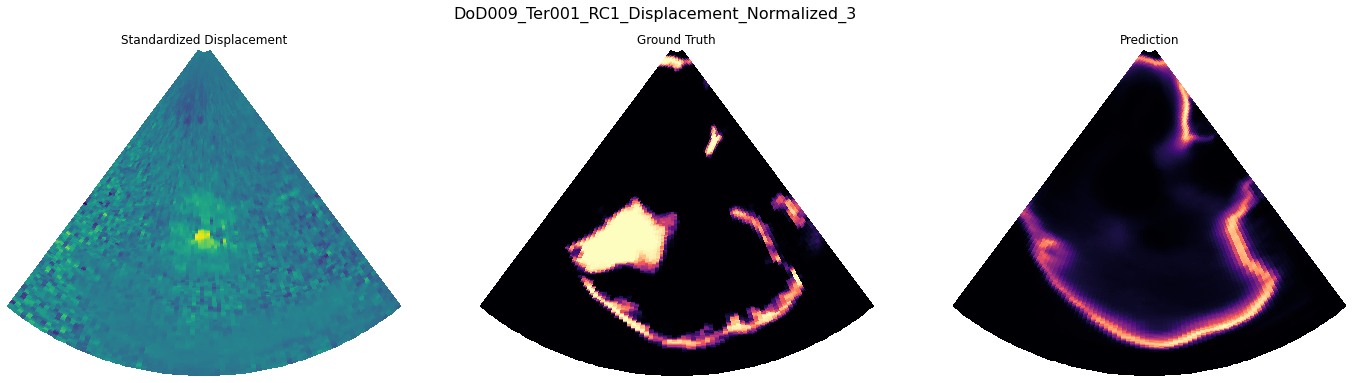

In [32]:
show_specific_prediction('DoD009_Ter001_RC1_Displacement_Normalized_3.mat',
                         hdf5_dir,
                         model)

/tmp/ipykernel_30340/4177526185.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma')
/tmp/ipykernel_30340/4177526185.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[2].pcolormesh(xAxis, -yAxis, prediction, shading='auto', cmap='magma')
/tmp/ipykernel_30340/4177526185.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges t

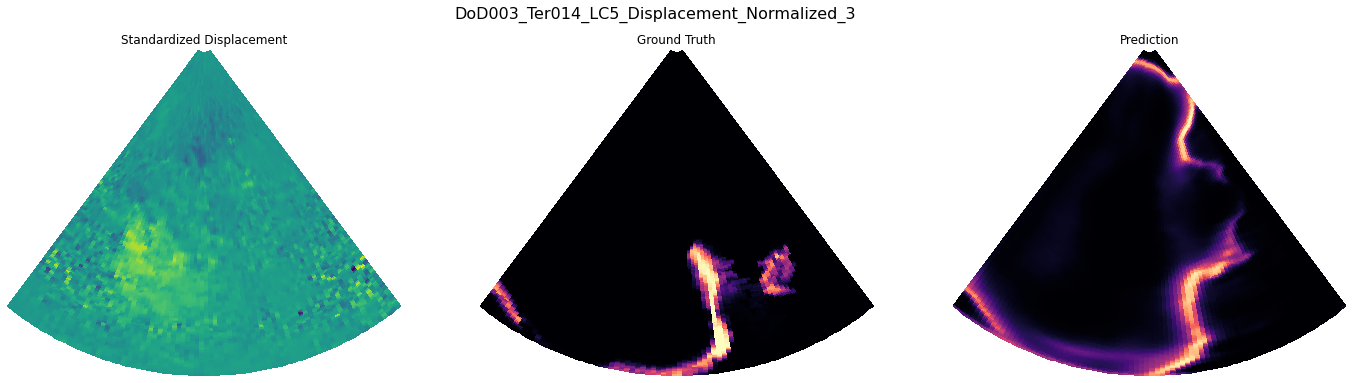

In [41]:
dataset = h5py.File(hdf5_dir, 'r')
show_prediction(model, dataset['test'], 24)
dataset.close()